## Importing libraries

In [1]:
import import_ipynb
from Reading_data import reading_data
from Cleaning_data import full_data_clean
from Nodes_and_edges import nodes_and_edges
from Nodes_and_edges import REWMH
import pandas as pd
import numpy as np
from numba import njit , jit
import math
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from sklearn.neural_network import MLPClassifier
from collections import Counter

importing Jupyter notebook from Reading_data.ipynb
importing Jupyter notebook from Cleaning_data.ipynb
importing Jupyter notebook from Nodes_and_edges.ipynb


In [2]:
%%time
events_called = 10
volumn_list = [8, 13, 17]
pt_cut_start = 1
pt_cut_end = 1.25
data_path = "Data/train_100_events/"

print(f"Reading data for {events_called} events:")
data_H_T , data_P = reading_data(data_path, events_called)

print(f"Cleaning data for {events_called} events:")
data_H_T_list = []
data_P_list = []
for __ in trange(events_called):
    data_1 , data_2 = full_data_clean(data_H_T[__], data_P[__], volumn_list, pt_cut_start, pt_cut_end)
    data_H_T_list.append(data_1)
    data_P_list.append(data_2)

print(f"Finding nodes for all {events_called} events:")
node_to_node_feat = [nodes_and_edges(data_H_T_list[i]) for i in trange(events_called)]

print(f"Splitting the data to {math.floor(len(node_to_node_feat)*0.95)} traning events:")
All_edges_TF_095 = [REWMH(node_to_node_feat[:math.floor(len(node_to_node_feat)*0.95)][i]) for i in trange(math.floor(len(node_to_node_feat)*0.95))]
All_edges_TF_095_combined = pd.concat(All_edges_TF_095, ignore_index=True)
print(f"Splitting the data to {math.floor(len(node_to_node_feat)*0.95)} testing events:")
All_edges_TF_005 = [REWMH(node_to_node_feat[-math.ceil(len(node_to_node_feat)*0.05):][i]) for i in trange(math.ceil(len(node_to_node_feat)*0.05))]
All_edges_TF_005_combined = pd.concat(All_edges_TF_005, ignore_index=True)

Reading data for 10 events:


  0%|          | 0/10 [00:00<?, ?it/s]

Cleaning data for 10 events:


  0%|          | 0/10 [00:00<?, ?it/s]

Finding nodes for all 10 events:


  0%|          | 0/10 [00:00<?, ?it/s]

Splitting the data to 9 traning events:


  0%|          | 0/9 [00:00<?, ?it/s]

Splitting the data to 9 testing events:


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: total: 21.9 s
Wall time: 22.4 s


In [3]:
def MLP_func(data_train,data_test,hidden_layer,max_iter):
    X_train = data_train[["z_node1","z_node2","r_node1","r_node2","phi_node1","phi_node2","x_node1","x_node2","y_node1","y_node2"]].copy()
    Y_train = data_train.Y_k
    X_test = data_test[["z_node1","z_node2","r_node1","r_node2","phi_node1","phi_node2","x_node1","x_node2","y_node1","y_node2"]].copy()
    Y_test = data_test.Y_k
    model = MLPClassifier(hidden_layer_sizes = hidden_layer, random_state=1, max_iter = max_iter)
    model.fit(X_train,Y_train)
    prop_train = model.predict(X_train)
    score_train = model.score(X_train,Y_train)
    prop_test = model.predict(X_test)
    score_test = model.score(X_test,Y_test)
    return model, X_train, Y_train, X_test, Y_test, prop_train, score_train, prop_test, score_test

In [20]:
%%time
model, X_train, Y_train, X_test, Y_test, prop_train, score_train, prop_test, score_test = MLP_func(All_edges_TF_095_combined, All_edges_TF_005_combined, (50,100), 100)

CPU times: total: 1min 27s
Wall time: 14.6 s


C:\Users\nicol\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [5]:
from sklearn.metrics import classification_report
print('Results on the traning set:')
print(classification_report(Y_train, prop_train))
print('Results on the test set:')
print(classification_report(Y_test, prop_test))

Results on the traning set:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     14650
         1.0       0.98      1.00      0.99     14667

    accuracy                           0.99     29317
   macro avg       0.99      0.99      0.99     29317
weighted avg       0.99      0.99      0.99     29317

Results on the test set:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      1611
         1.0       0.98      1.00      0.99      1620

    accuracy                           0.99      3231
   macro avg       0.99      0.99      0.99      3231
weighted avg       0.99      0.99      0.99      3231



In [6]:
def plot_func(X_test, prop_test, XY, ZR, figure_size):
    X_test_index = X_test.reset_index().drop("index",axis = 1)
    X_true = []
    for i, idx in enumerate(range(len(prop_test))):
        if prop_test[i] == 1:
            X_true.append(X_test_index.loc[idx])
    plt.rcParams['figure.figsize'] = figure_size
    edges = np.array(X_true)
    xyz = edges
    print(len(xyz))
    for i in range(len(xyz)):
        if XY == True:
            px = np.array([xyz[i,6],xyz[i,7]])
            py = np.array([xyz[i,8], xyz[i,9]])
            plt.scatter(px,py, s = 10, color = 'black')
            plt.plot(px,py, '--', alpha = 0.3, color = 'b')
            plt.xlim(-1100,1100)
            plt.ylim(-1100,1100)
        elif ZR == True:
                px = np.array([xyz[i,0],xyz[i,1]])
                py = np.array([xyz[i,2], xyz[i,3]])
                plt.scatter(px,py, s = 10, color = 'black')
                plt.plot(px,py, '--', alpha = 0.3, color = 'b')

In [7]:
#%%time
#plot_func(X_test, prop_test, True, False, [5,5])

In [8]:
def particle_track_plot(X_test, prop_test, figure_size):
    X_true = X_test.loc[prop_test == 1]
    px = np.array([X_true.iloc[:, 6], X_true.iloc[:, 7]])
    py = np.array([X_true.iloc[:, 8], X_true.iloc[:, 9]])
    plt.rcParams['figure.figsize'] = figure_size
    plt.scatter(px, py, s = 10, color = 'black')
    plt.plot(px, py, '--', alpha = 0.3, color = 'b')
    plt.xlim(-1100, 1100)
    plt.ylim(-1100, 1100)
    plt.xlabel('x [mm]', fontsize = 20)
    plt.ylabel('y [mm]', fontsize = 20)


CPU times: total: 766 ms
Wall time: 380 ms


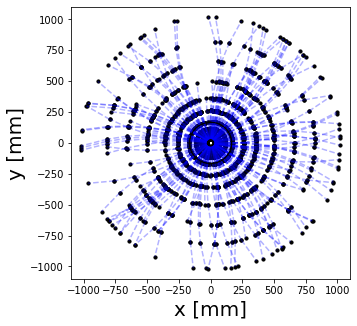

In [9]:
%%time
x_true = particle_track_plot(X_test, prop_test, [5, 5])

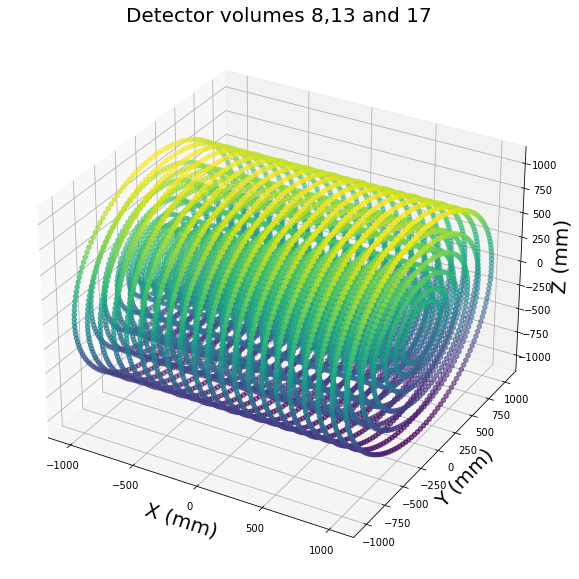

In [25]:
det = pd.read_csv('Data/detectors.csv')
layers = det.drop(det[(det.volume_id != 7) & (det.volume_id != 12) & (det.volume_id !=16)].index) #

def remove_volume_ids(data_H_T, volumn_list):
    data_H_T = data_H_T.loc[data_H_T['volume_id'].isin(volumn_list)]
    return data_H_T

layers = remove_volume_ids(det, [8 , 13, 17])


plt.figure(1, figsize = (10,10))
ax = plt.axes(projection='3d')
#ax.set_facecolor('xkcd:black')
ax.set_title(f"Detector volumes{[8 , 13, 17]}",fontsize = 20)#.set_position([.5, .002])
ax.set_xlabel('X (mm)', fontsize=20, rotation = 0)
ax.set_ylabel('Y (mm)', fontsize=20, rotation = 0)
ax.set_zlabel('Z (mm)', fontsize=20, rotation = 0)
ax.scatter3D(layers.cz,layers.cx,layers.cy, c = layers.cy)


In [11]:
truedf = X_test.loc[Y_test == 1]
x_node1 = np.array(truedf.x_node1)
x_node2 = np.array(truedf.x_node2)
y_node1 = np.array(truedf.y_node1)
y_node2 = np.array(truedf.y_node2)
z_node1 = np.array(truedf.z_node1)
z_node2 = np.array(truedf.z_node2)

In [12]:
%%time

@njit(error_model='numpy')
def segment_finder(x_node1, x_node2, y_node1, y_node2, z_node1, z_node2):
    segment = []
    for i, idx in enumerate(range(len(x_node1))):
        for k, kdx in enumerate(range(len(x_node1))):
            if i <= 2500 and z_node2[i] == z_node1[k] and y_node2[i] == y_node1[k] and x_node2[i] == x_node1[k]:
                segment.append([idx, kdx])
            if i > 2500 and z_node2[k] == z_node1[i] and y_node2[k] == y_node1[i] and x_node2[k] == x_node1[i]:
                segment.append([kdx, idx])

    seg1 = []
    for i in range(len(segment)):
        for k in range(len(segment)):
            if segment[i][1] == segment[k][0]:
                seg1.append([segment[i][0], segment[i][1], segment[k][1]])

    seg2 = []
    for i in range(len(seg1)):
        for k in range(len(seg1)):
            if seg1[i][2] == seg1[k][0]:
                seg2.append([seg1[i][0],seg1[i][1], seg1[k][0],seg1[k][1],seg1[k][2]])
    seg3 = []
    for i in range(len(seg2)):
        for k in range(len(seg2)):
            if seg2[i][4] == seg2[k][0]:
                seg3.append([seg2[i][0], seg2[i][1], seg2[i][2], seg2[i][3],seg2[k][0], seg2[k][1],seg2[k][2],seg2[k][3],seg2[k][4]])
                
    return seg1 , seg2 , seg3

CPU times: total: 15.6 ms
Wall time: 997 µs


In [13]:
%%time
seg1 , seg2 , seg3 = segment_finder(x_node1, x_node2, y_node1, y_node2, z_node1, z_node2)

CPU times: total: 719 ms
Wall time: 729 ms


In [14]:
print(len(seg3))

76


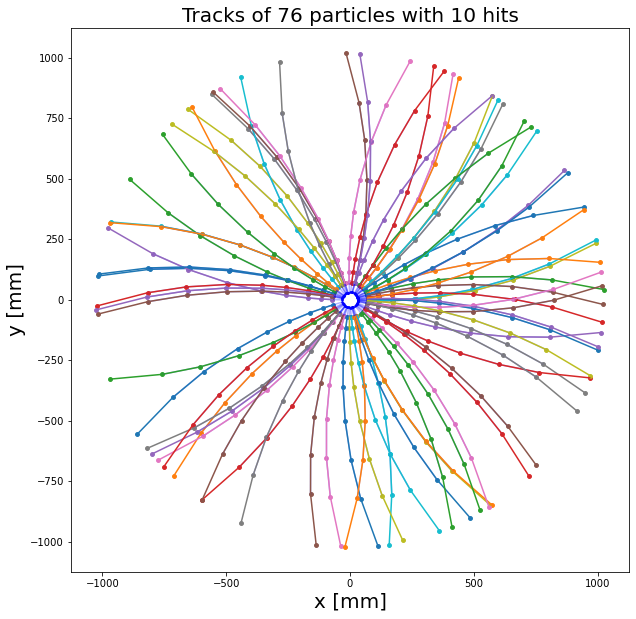

CPU times: total: 10.4 s
Wall time: 10.4 s


In [15]:
%%time
plt.figure(figsize=(10,10))
for i in seg3:
    plt.plot(truedf.x_node1[i], truedf.y_node1[i], color = 'blue', alpha = 0.3)
    plt.scatter(truedf.x_node1[i], truedf.y_node1[i], color = 'blue', s = 2)
    plt.scatter(truedf.x_node2[i], truedf.y_node2[i], s = 15)
    plt.plot(truedf.x_node2[i], truedf.y_node2[i])
plt.xlabel('x [mm]', fontsize = 20)
plt.ylabel('y [mm]', fontsize = 20)
plt.title(f"""Tracks of {len(seg3)} particles with 10 hits""", fontsize = 20)
plt.show()

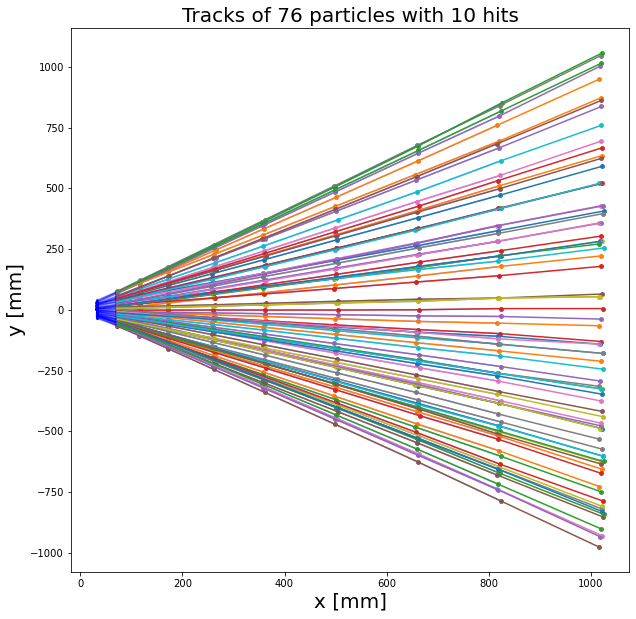

CPU times: total: 10.1 s
Wall time: 10.1 s


In [16]:
%%time
plt.figure(figsize=(10,10))
for i in seg3:
    plt.plot(truedf.r_node1[i], truedf.z_node1[i], color = 'blue', alpha = 0.3)
    plt.scatter(truedf.r_node1[i], truedf.z_node1[i], color = 'blue', s = 2)
    plt.scatter(truedf.r_node2[i], truedf.z_node2[i], s = 15)
    plt.plot(truedf.r_node2[i], truedf.z_node2[i])
plt.xlabel('x [mm]', fontsize = 20)
plt.ylabel('y [mm]', fontsize = 20)
plt.title(f"""Tracks of {len(seg3)} particles with 10 hits""", fontsize = 20)
plt.show()